# PLANT LEAVES ANALYSIS - CANYELLES VINEYARD
In this notebook you will find an analysis of vineyard plant leaves.

## Previous steps
To make it work:

- Download the [PLANT LEAVES ZENODO DATASET](https://zenodo.org/records/13944498).
- Unzip and add the plant images to a folder called PLANT_LEAVES in the correct *source_directory* variable path.
- Execute the code :)

## Execution flow

- Import libraries.
- Load plant images to a dictionary with more variables.
- Detects the number of components (brown spots in the leaves) and the area that these components occupy and classify the plant leaves.
- Compute VARI index (vegetation index with RGB) to classify the leaves.
- Uses KMeans unsupervised learning method to make a cluster classification with the features extracted.

## Import libraries

In [1]:
import os
import cv2
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
#from google.colab import drive

## Load plant images

In [2]:
# Path definition
#source_directory = "/content/drive/MyDrive/PLANT_LEAVES/"
source_directory = "/home/noumena/Documents/ICAERUS/PLANT_LEAVES/"

# Mount drive
#drive.mount('/content/drive')

In [3]:
# Define the variables to save the leaves information
dict_init = {"1B":[], "2C":[], "6A":[], "9B":[], "10B":[], "14B":[], "18A":[], "18B":[],
              "18C":[], "23B":[], "26B":[], "30B":[], "30C":[], "32B":[], "39A":[], "39C":[]}
keys = list(dict_init.keys())
dates = ['May 10', 'May 23', 'Jun 18', 'Jul 3', 'Jul 17', 'Jul 31', 'Aug 13', 'Aug 30']

# Leaves dictionary with variables
leaves_dict = copy.deepcopy(dict_init)
for key in leaves_dict:
      leaves_dict[key] = {"path": [], "image": [], "leaf_mask": [], "date": [], "components": [], "area":[], "vari":[]}

In [4]:
# List of folders with plant images
day_plant_folders = sorted(os.listdir(source_directory))

# For each plant folder
for day_plant_folder in tqdm(day_plant_folders):
  day_leaves_path = source_directory + day_plant_folder
  all_day_leaves = sorted(os.listdir(day_leaves_path))

  # For each plant image in the folder
  for leave in all_day_leaves:
    leave_path = day_leaves_path + '/' + leave
    # If it's a front leave image
    if(leave.split('_')[-1].split('.')[0] == "front"):
      image = cv2.imread(leave_path)
      # Resize the plant image if it's JPG
      if(leave.split('_')[-1].split('.')[-1] == 'JPG'):
        image = cv2.resize(image,(120,160))

      # Save data to dictionary
      key = leave.split('_')[0]
      leaves_dict[key]["path"].append(leave_path)
      leaves_dict[key]["image"].append(image)
      leaves_dict[key]["date"].append(day_plant_folder.split('_')[0] + '_' + leave_path)

100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.18it/s]


## Calculate components and diseased area


In [5]:
# Define kernel and ranges for filtering
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
low_range_leave = np.array([0, 25, 25])
up_range_leave = np.array([90, 255, 255])
low_orange = np.array([0, 100, 100])
up_orange = np.array([28, 255, 255])


# For each leave in each date
for key in keys:
    for image in leaves_dict[key]["image"]:

      # Convert the masked image to the HSV color space
      hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

      # Detect leaf
      leaf_mask = cv2.inRange(hsv_image, low_range_leave, up_range_leave)

      # Create a mask that identifies orange regions within the leaf
      orange_mask = cv2.inRange(hsv_image, low_orange, up_orange)
      orange_mask = cv2.morphologyEx(orange_mask, cv2.MORPH_CLOSE, kernel, iterations = 1)

      # Detect orange spots in the leave
      num_labels, labels = cv2.connectedComponents(orange_mask)

      # Calculate the number of orange (diseased) pixels within the leaf
      diseased_pixels = np.sum(orange_mask > 0)
      total_leaf_pixels = np.sum(leaf_mask > 0)

      if total_leaf_pixels > 0:
          percentage_diseased = (diseased_pixels / total_leaf_pixels) * 100
      else:
          percentage_diseased = 0

      # Save mask, components and area
      leaves_dict[key]['leaf_mask'].append(leaf_mask)
      leaves_dict[key]['components'].append(num_labels-1)
      leaves_dict[key]['area'].append(percentage_diseased)

/tmp/ipykernel_24615/3501288625.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', n_labels)


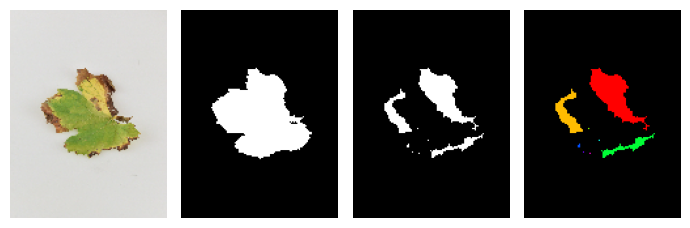

In [6]:
# Shows an example of the leaf filtered and its detected components
fig, axs = plt.subplots(1, 4, figsize=(7, 5))

axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].axis('off')

axs[1].imshow(leaf_mask, cmap='gray')
axs[1].axis('off')

axs[2].imshow(orange_mask, cmap='gray')
axs[2].axis('off')

n_labels = np.max(labels) + 1
colors = plt.cm.get_cmap('hsv', n_labels)
colored_labels = label2rgb(labels, colors=colors(np.arange(n_labels)), bg_label=0)

axs[3].imshow(colored_labels)
axs[3].axis('off')

plt.tight_layout()
plt.show()

### Detect diseased leaves based on components and area

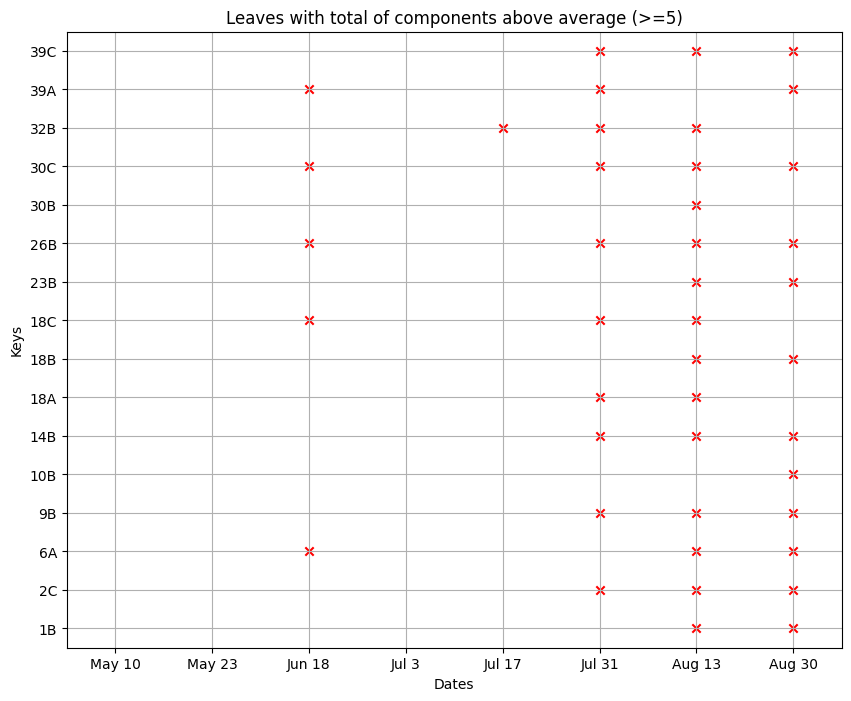

In [7]:
# DISEASED PLANTS DEPENDING ON NUMBER OF COMPONENTS

# Organize data and get mean data
data_values = [leaves_dict[key]['components'] for key in keys]
mean_value = np.mean([np.mean(values) for values in data_values])

# Save coordinates if value is above mean_value
x_coords = []
y_coords = []

for y, row in enumerate(data_values):
    for x, val in enumerate(row):
        if val >= mean_value:
            x_coords.append(x)
            y_coords.append(y)


# Create the scatter plot
plt.figure(figsize=(10, 8), facecolor=(1,1,1))
plt.scatter(x_coords, y_coords, color='red', marker='x')

plt.xlabel('Dates')
plt.ylabel('Keys')
plt.xlim(-0.5, len(dates)-0.5)
plt.ylim(-0.5, len(keys)-0.5)
plt.xticks(ticks=np.arange(len(dates)), labels=dates)
plt.yticks(ticks=np.arange(len(keys)), labels=keys)
plt.grid(True)
plt.title('Leaves with total of components above average (>=' + str(int(mean_value)) + ')')
plt.show()

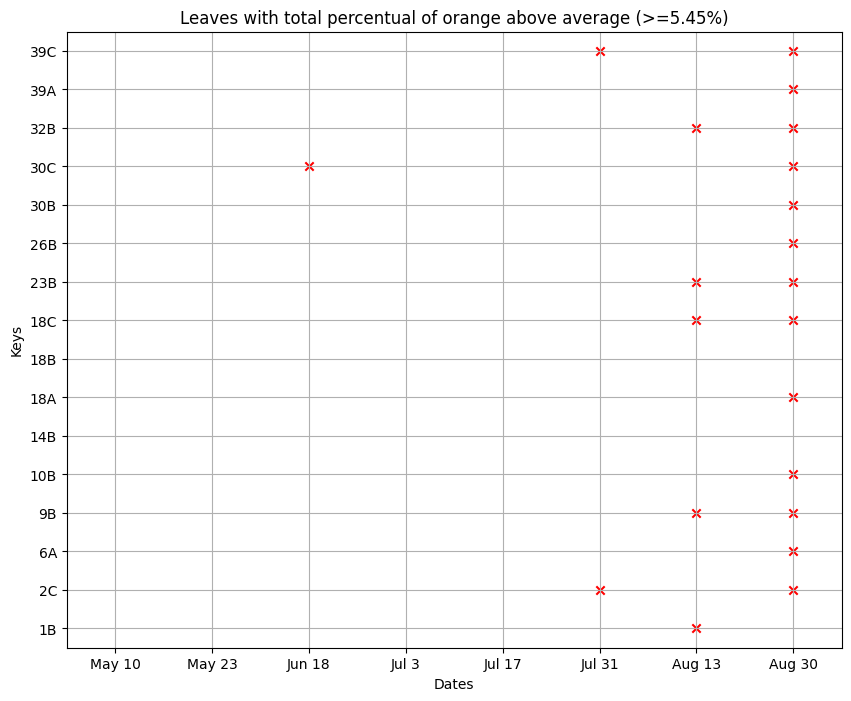

In [8]:
# DISEASED LEAVES DEPENDING ON AREA

# Organize data and get mean data
data_values = [leaves_dict[key]['area'] for key in keys]
mean_value = np.mean([np.mean(values) for values in data_values])

# Save coordinates if value is above mean_value
x_coords = []
y_coords = []
for y, row in enumerate(data_values):
    for x, val in enumerate(row):
        if val >= mean_value:
            x_coords.append(x)
            y_coords.append(y)


# Create the scatter plot
plt.figure(figsize=(10, 8), facecolor=(1,1,1))
plt.scatter(x_coords, y_coords, color='red', marker='x')

plt.xlabel('Dates')
plt.ylabel('Keys')
plt.xlim(-0.5, len(dates)-0.5)
plt.ylim(-0.5, len(keys)-0.5)
plt.xticks(ticks=np.arange(len(dates)), labels=dates)
plt.yticks(ticks=np.arange(len(keys)), labels=keys)
plt.grid(True)
plt.title('Leaves with total percentual of orange above average (>=' + str(np.round(mean_value,2)) + '%)')
plt.show()

## Compute VARI index

VARI index is a way of calculating the *greeness* of a plant when we have an RGB image. This value is between -1 and 1, meaning that values near 1 will be associate it with healthier plants (*greener*).

In [9]:
# Calculate VARI index only on the leaves
def calculate_vari(image, leaf_mask):
    image = image.astype(np.float32)
    B, G, R = cv2.split(image)
    vari = []
    for i in range(leaf_mask.shape[0]):
        for j in range(leaf_mask.shape[1]):
            if leaf_mask[i][j] != 0:
                vari.append( (G[i][j] - R[i][j]) / (G[i][j] + R[i][j] + 1e-10))

    return vari

In [10]:
# Calculate mean VARI index per image and save
for key in tqdm(keys):
  for image, leaf_mask in zip(leaves_dict[key]["image"], leaves_dict[key]["leaf_mask"]):
    mean_vari = np.mean(calculate_vari(image, leaf_mask))
    leaves_dict[key]["vari"].append(mean_vari)

100%|███████████████████████████████████████████| 16/16 [00:03<00:00,  5.06it/s]


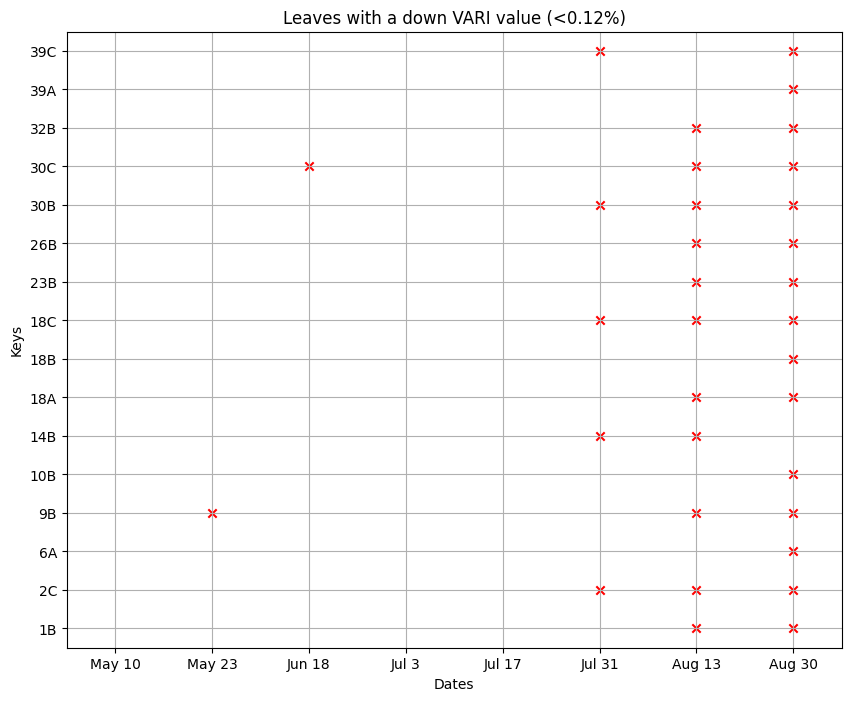

In [11]:
# DISEASED PLANTS DEPENDING ON VARI INDEX

# Organize data and filter depending on the VARI value
data_values = [leaves_dict[key]['vari'] for key in leaves_dict.keys()]
x_coords = []
y_coords = []
for y, row in enumerate(data_values):
    for x, val in enumerate(row):
        if val < 0.12:
            x_coords.append(x)
            y_coords.append(y)


# Create the scatter plot
plt.figure(figsize=(10, 8), facecolor=(1,1,1))
plt.scatter(x_coords, y_coords, color='red', marker='x')

plt.xlabel('Dates')
plt.ylabel('Keys')
plt.xlim(-0.5, len(dates)-0.5)
plt.ylim(-0.5, len(keys)-0.5)
plt.xticks(ticks=np.arange(len(dates)), labels=dates)
plt.yticks(ticks=np.arange(len(keys)), labels=keys)
plt.grid(True)
plt.title('Leaves with a down VARI value (<' + str(0.12) + '%)')
plt.show()

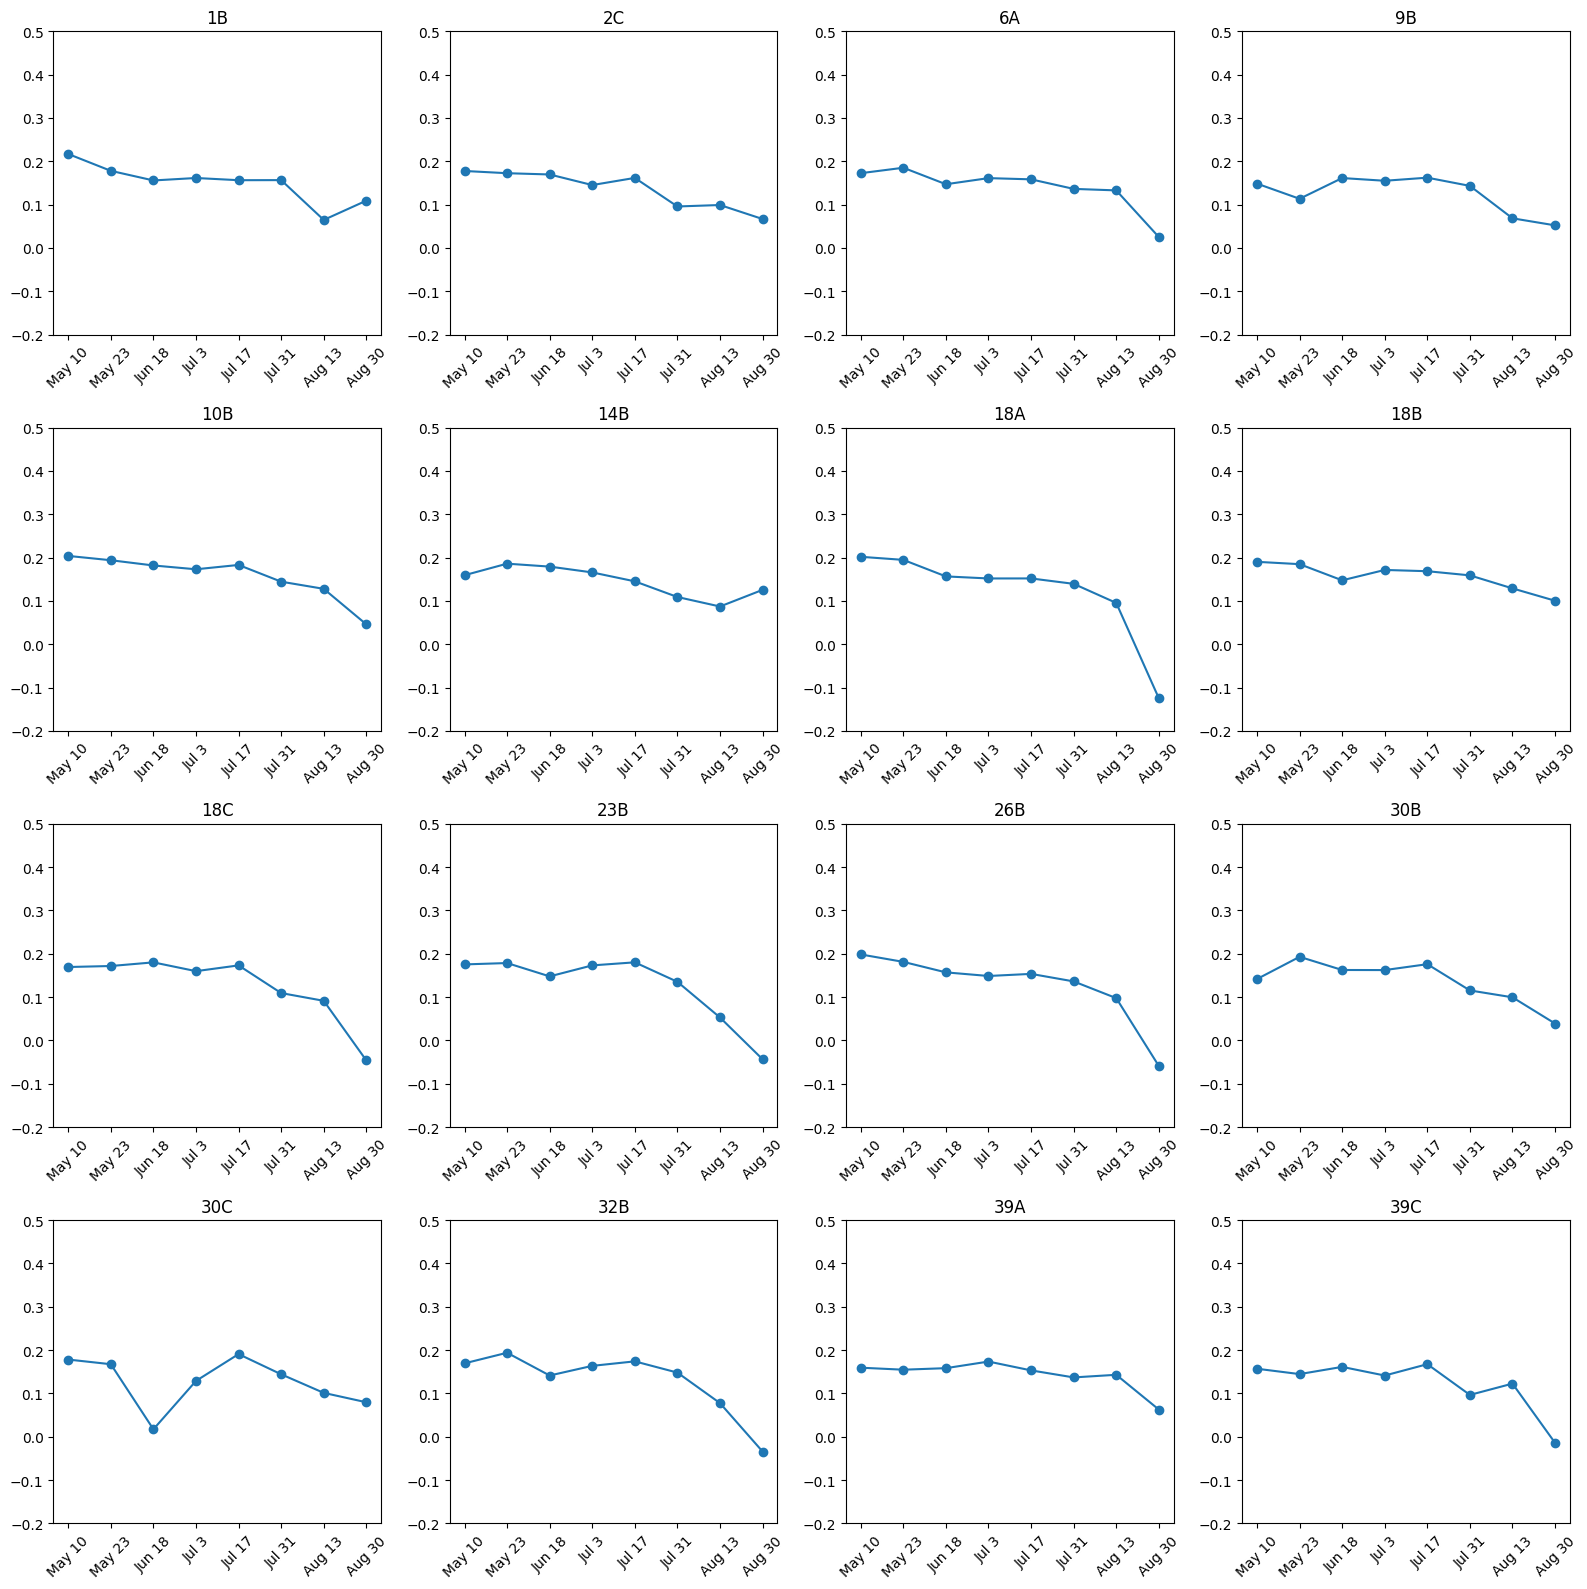

In [12]:
# Show VARI index for each plant over time
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.ravel()

for k, ax in enumerate(axs):
    ax.plot(dates, data_values[k], marker='o')  # Agregar puntos a cada valor
    ax.set_title(keys[k])
    ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje X a 45 grados
    ax.set_ylim(-0.2, 0.5)

plt.tight_layout()
plt.show()

## Unsupervised learning analysis


### KMeans - Components and area

Apply kmeans algorithm using components and area features


In [13]:
# Organize kmeans data
kmeans_data = []
for key in leaves_dict.keys():
  for i in range(len(leaves_dict[key]['components'])):
    kmeans_data.append([leaves_dict[key]['components'][i], leaves_dict[key]['area'][i]])
kmeans_data = np.array(kmeans_data)

In [14]:
# KMEANS CLUSTERING
# Define the number of clusters (you can change this number)
num_clusters = 3

# Create the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit the model to the data
kmeans.fit(kmeans_data)

# Get the cluster labels
kmeans_labels = kmeans.labels_
kmeans_labels = kmeans_labels.reshape(16,8)
centers = kmeans.cluster_centers_

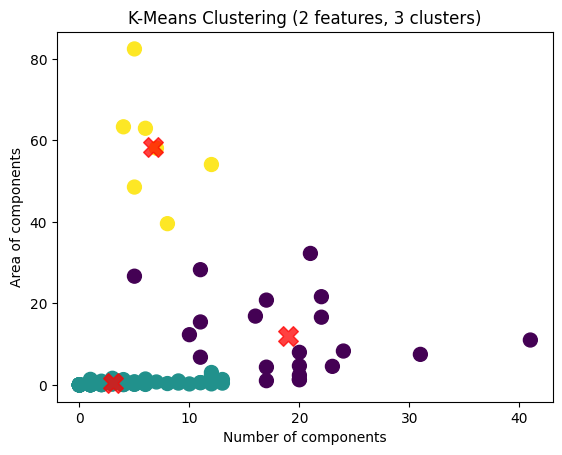

In [15]:
# Plot the data points and cluster centers
plt.scatter(kmeans_data[:, 0], kmeans_data[:, 1], c=kmeans_labels, s=100, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-Means Clustering (2 features, 3 clusters)')
plt.xlabel('Number of components')
plt.ylabel('Area of components')
plt.show()

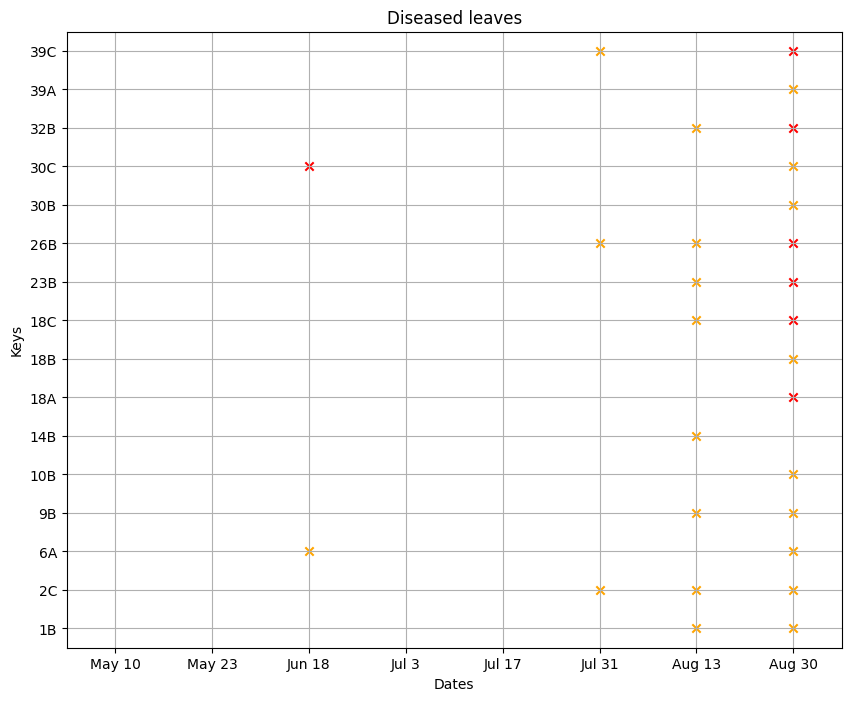

In [16]:
# DISEASED PLANTS DEPENDING ON THE KMEAN CLASSIFICATION

# Get clustered leaves coordinates
x_coords0 = []
y_coords0 = []
x_coords1 = []
y_coords1 = []

for y, row in enumerate(kmeans_labels):
    for x, val in enumerate(row):
        if val == 2:
            x_coords0.append(x)
            y_coords0.append(y)
        elif val == 0:
            x_coords1.append(x)
            y_coords1.append(y)

# Create the scatter plot
plt.figure(figsize=(10, 8), facecolor=(1,1,1))
plt.scatter(x_coords0, y_coords0, color='red', marker='x')
plt.scatter(x_coords1, y_coords1, color='orange', marker='x')

plt.xlabel('Dates')
plt.ylabel('Keys')
plt.xlim(-0.5, len(dates)-0.5)
plt.ylim(-0.5, len(keys)-0.5)
plt.xticks(ticks=np.arange(len(dates)), labels=dates)
plt.yticks(ticks=np.arange(len(keys)), labels=keys)
plt.grid(True)
plt.title('Diseased leaves')
plt.show()

Apply kmeans algorithm using components, area and vari features


### KMeans - Components, area and VARI

In [17]:
# Organize kmeans data
kmeans_data = []
for key in leaves_dict.keys():
  for i in range(len(leaves_dict[key]['components'])):
    kmeans_data.append([leaves_dict[key]['components'][i], leaves_dict[key]['area'][i], leaves_dict[key]['vari'][i]])
kmeans_data = np.array(kmeans_data)

In [18]:
# KMEANS CLUSTERING
# Define the number of clusters (this can be changed)
num_clusters = 3

# Create the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit the model to the data
kmeans.fit(kmeans_data)

# Get the cluster labels
kmeans_labels = kmeans.labels_
kmeans_labels = kmeans_labels.reshape(16,8)
centers = kmeans.cluster_centers_

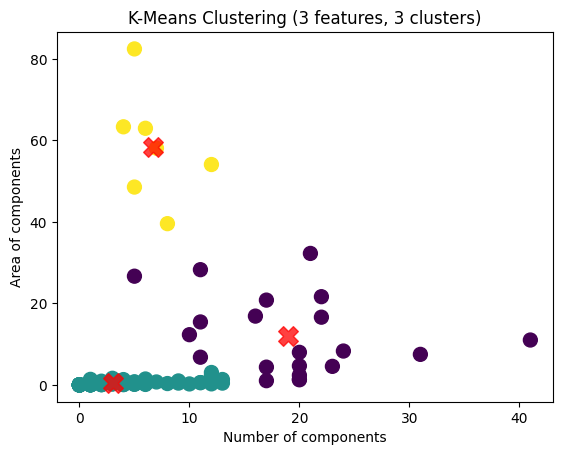

In [19]:
# Plot the data points and cluster centers
plt.scatter(kmeans_data[:, 0], kmeans_data[:, 1], c=kmeans_labels, s=100, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-Means Clustering (3 features, 3 clusters)')
plt.xlabel('Number of components')
plt.ylabel('Area of components')
plt.show()

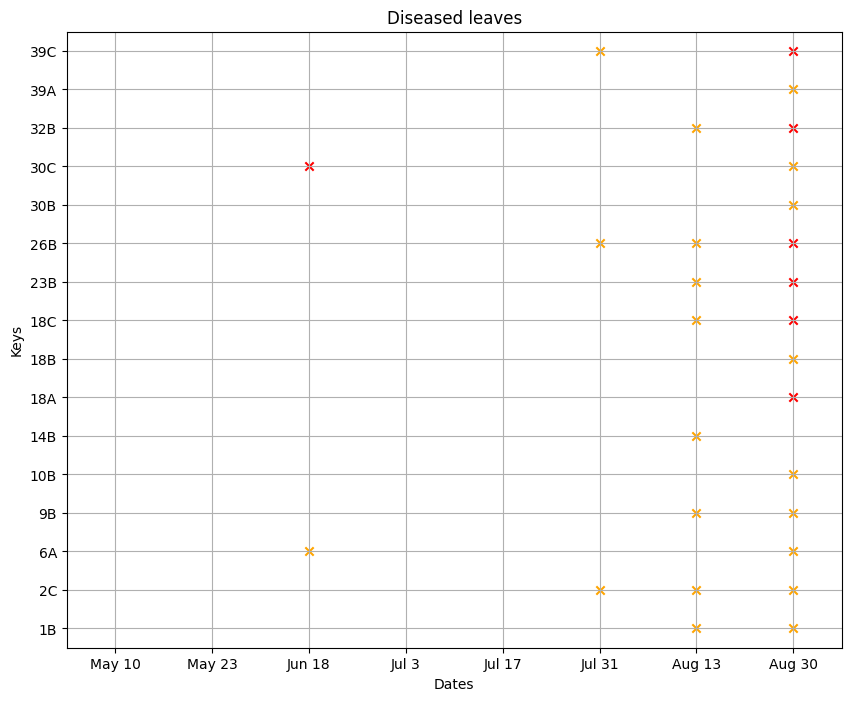

In [20]:
# DISEASED PLANTS DEPENDING ON THE KMEAN CLASSIFICATION

# Get clustered leaves coordinates
x_coords0 = []
y_coords0 = []
x_coords1 = []
y_coords1 = []

for y, row in enumerate(kmeans_labels):
    for x, val in enumerate(row):
        if val == 2:
            x_coords0.append(x)
            y_coords0.append(y)
        elif val == 0:
            x_coords1.append(x)
            y_coords1.append(y)

# Create the scatter plot
plt.figure(figsize=(10, 8), facecolor=(1,1,1))
plt.scatter(x_coords0, y_coords0, color='red', marker='x')
plt.scatter(x_coords1, y_coords1, color='orange', marker='x')

plt.xlabel('Dates')
plt.ylabel('Keys')
plt.xlim(-0.5, len(dates)-0.5)
plt.ylim(-0.5, len(keys)-0.5)
plt.xticks(ticks=np.arange(len(dates)), labels=dates)
plt.yticks(ticks=np.arange(len(keys)), labels=keys)
plt.grid(True)
plt.title('Diseased leaves')
plt.show()

### Export leaves data

In [21]:
leaves_values = {'date':[], 'name':[],'vari':[], 'health':[]}
for leaf in leaves_dict: 
    for path, vari in zip(leaves_dict[str(leaf)]['path'], leaves_dict[str(leaf)]['vari']):
        date = path.split('/')[-2].split('_')[0]
        health = ((vari + 1) * 100) / 2
        leaves_values['date'].append(date)
        leaves_values['name'].append(leaf)
        leaves_values['vari'].append(vari)
        leaves_values['health'].append(health)

In [22]:
# Guardar en un archivo JSON
import json
with open("leaves_data.json", "w") as json_file:
    json.dump(leaves_values, json_file, indent=4)

print("Exported data as leaves_data.json")

Exported data as leaves_data.json


In [24]:
leaves_values['date'][

['240510',
 '240523',
 '240618',
 '240703',
 '240717',
 '240731',
 '240813',
 '240830',
 '240510',
 '240523',
 '240618',
 '240703',
 '240717',
 '240731',
 '240813',
 '240830',
 '240510',
 '240523',
 '240618',
 '240703',
 '240717',
 '240731',
 '240813',
 '240830',
 '240510',
 '240523',
 '240618',
 '240703',
 '240717',
 '240731',
 '240813',
 '240830',
 '240510',
 '240523',
 '240618',
 '240703',
 '240717',
 '240731',
 '240813',
 '240830',
 '240510',
 '240523',
 '240618',
 '240703',
 '240717',
 '240731',
 '240813',
 '240830',
 '240510',
 '240523',
 '240618',
 '240703',
 '240717',
 '240731',
 '240813',
 '240830',
 '240510',
 '240523',
 '240618',
 '240703',
 '240717',
 '240731',
 '240813',
 '240830',
 '240510',
 '240523',
 '240618',
 '240703',
 '240717',
 '240731',
 '240813',
 '240830',
 '240523',
 '240523',
 '240618',
 '240703',
 '240717',
 '240731',
 '240813',
 '240830',
 '240510',
 '240523',
 '240618',
 '240703',
 '240717',
 '240731',
 '240813',
 '240830',
 '240510',
 '240523',
 '240618',

In [30]:
for i,date in enumerate(leaves_values['date']): 
    if(date == '240830'):
        print(leaves_values['name'][i], leaves_values['health'][i], leaves_values['vari'][i])
    

1B 55.46142552119492 0.10922851042389828
2C 53.34432814850925 0.06688656297018482
6A 51.26564458817487 0.02531289176349752
9B 52.61176636997108 0.0522353273994215
10B 52.29357048157954 0.045871409631590955
14B 56.27446776762432 0.1254893553524864
18A 43.76943548454891 -0.12461129030902186
18B 55.01949107245723 0.10038982144914463
18C 47.7002285786118 -0.04599542842776394
23B 47.83367787006018 -0.04332644259879635
26B 47.05887364298922 -0.058822527140215596
30B 51.955749498771176 0.039114989975423516
30C 53.978657246361685 0.07957314492723358
32B 48.29326564690147 -0.034134687061970655
39A 53.13731237813466 0.0627462475626931
39C 49.29102650262894 -0.014179469947421279
